<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture1/minist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### データの準備と描画

`sklearn.datasets`のMNISTデータを読み込んだ後に、画像データとその画像データのターゲット（数値）データを分けて変数に格納する。

(1797, 8, 8)


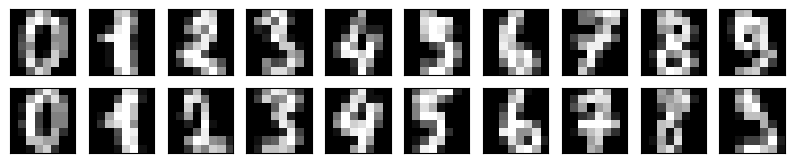

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

X = datasets.load_digits()

# print(X["target"])
# print(X["images"])

images = X["images"]
target = X["target"]

print(images.shape) # --> (1797, 8, 8) --> (data_num, height, width)

# 新しい図を幅と高さを(10,10)で作成する
fig = plt.figure(figsize=(10, 10))

# 図を20枚作成する
for i in range(20):
    x = images[i]
    # 同じ図内に複数のグラフを配置する
    ax = fig.add_subplot(10, 10, i + 1,  xticks=[], yticks=[])
    ax.imshow(x, "gray")
plt.show()

### 前処理

ソフトマックスやロジスティック回帰での分類を行うために、画像データを１次元データに変換する。
また、目的変数をOne-Hotエンコーディングしておく

In [2]:
import torch

# 目的変数をOne-Hotエンコーディングする
y = torch.nn.functional.one_hot(torch.tensor(target), num_classes=10)

# 画像データの次元を変更
X = torch.flatten(torch.tensor(images, dtype=torch.float32), start_dim=1)
# 上記と同じ処理 ---->  X = torch.tensor(images, dtype=torch.float32).reshape(-1, 16)

# 画像データの標準化
# X = (X - X.mean()) / X.std()

# 画像データを正規化
X = X / 255.0

### パラメータ初期化

`torch.rand()`を用いて、パラメータを初期化する。ここで、requires_grad=Trueを設定しておくことで、勾配の計算を自動で行えるようにしておく。

In [3]:
W = torch.rand((10, 64), requires_grad=True) # 出力 x 入力
b = torch.rand((1, 10), requires_grad=True) # 1 x 入力

### 損失関数とsoftmax関数実装

In [4]:
def softmax(x):
    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])
    return e_x / (torch.sum(e_x, dim=-1, keepdim=True) + 1e-10)

def cross_entropy(y_true, y_pred):
    return -torch.sum(y_true * torch.log(y_pred + 1e-10)) / y_true.shape[0]

### 学習

In [5]:
learning_rate = 0.03
loss_log = []

In [6]:
for epoch in range(5):
    running_loss = 0
    for i in range(len(target)):
        # 6. 入力データXおよび教師ラベルのYを作成
        y_true_ = y[i].reshape(-1, 10) # データ数xクラス数
        x = X[i].reshape(-1, 64) # データ数 x 特徴量数

        # 7. Z計算
        Z = x@W.T + b

        # 8. softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()

        # 10. 勾配計算
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: {running_loss/len(target)}')

epoch: 1: 2.2944393736425877
epoch: 2: 2.2498950686266372
epoch: 3: 2.209718130334059
epoch: 4: 2.170413573383953
epoch: 5: 2.131973351713148


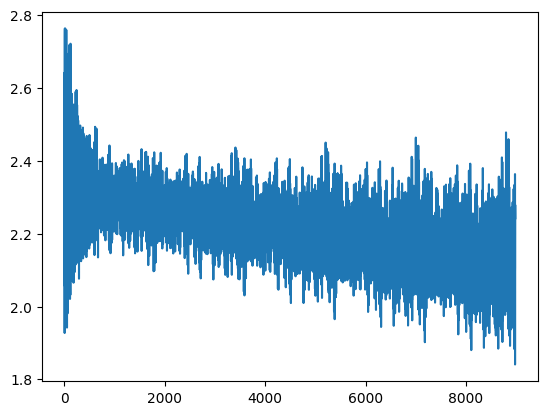

In [7]:
plt.plot(loss_log)

### Mini-Batch 学習

In [8]:
# ランダムにソートされたindexを使ってデータを取得することで，X, yを同時にshuffleすることが可能
np.random.permutation(len(target))

array([ 697, 1251,  656, ...,  764, 1182,  266])

In [9]:
loss_log = []
batch_size = 30
num_batches = np.ceil(len(target) / batch_size).astype(int)
# 3. パラメータの初期化
W = torch.rand((10, 64), requires_grad=True) # 出力x入力
b = torch.rand((1, 10), requires_grad=True) # 1 x 出力
# 5. for文で学習ループ作成
for epoch in range(5):
    shuffled_indices = np.random.permutation(len(target))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        if end > len(target):
            end = len(target) # Adjust end index to avoid going out of bounds
        batch_indices = shuffled_indices[start:end]

        # 6. 入力データXおよび教師ラベルのYを作成
        # Assuming 'y' is the variable containing all labels:
        y_true_ = y[batch_indices]  # データ数xクラス数
        x = X[batch_indices, :] # データ数 x 特徴量数

        # 7. Z計算
        Z = x@W.T + b

        # 8. softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()

        # 10. 勾配計算
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: {running_loss/num_batches}')

epoch: 1: 2.3483107924461364
epoch: 2: 2.3349910497665407
epoch: 3: 2.3255149006843565
epoch: 4: 2.3185566703478497
epoch: 5: 2.313324975967407


### 学習データと検証データを分ける

In [10]:
# 1. データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

In [11]:
from sklearn.model_selection import train_test_split

# 学習データと検証データ分割
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1437, 8, 8) (1437,)
(360, 8, 8) (360,)


In [12]:
# 2-1.ラベルのone-hot encoing
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=10)
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)

y_val = torch.nn.functional.one_hot(torch.tensor(y_val), num_classes=10)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2. 画像の標準化
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std

In [13]:
batch_size = 30
num_batches = np.ceil(len(y_train) / batch_size).astype(int)
loss_log = []
# 3. パラメータの初期化
W = torch.rand((10, 64), requires_grad=True) # 出力x入力
b = torch.rand((1, 10), requires_grad=True) # 1 x 出力
# ログ
train_losses = []
val_losses = []
val_accuracies = []
# 5. for文で学習ループ作成
epochs = 30
for epoch in range(epochs):
    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]
        # 6. 入力データXおよび教師ラベルのYを作成
        y_true_ = y_train[batch_indices, :] # データ数xクラス数
        X = X_train[batch_indices, :] # データ数 x 特徴量数
        # import pdb; pdb.set_trace()

        # 7. Z計算
        Z = X@W.T + b

        # 8. softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()

        # 10. 勾配計算
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()
    # validation
    with torch.no_grad():
        Z_val = X_val@W.T + b
        y_pred_val = softmax(Z_val)

        val_loss = cross_entropy(y_val, y_pred_val)
        val_accuracy = torch.sum(torch.argmax(y_pred_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: train loss:{running_loss/num_batches}, val loss: {val_loss.item()}, val accuracy: {val_accuracy.item()}')

epoch: 1: train loss:2.4826497758428254, val loss: 1.5551624298095703, val accuracy: 0.49444442987442017
epoch: 2: train loss:1.2448181596895058, val loss: 0.9534836411476135, val accuracy: 0.7333333492279053
epoch: 3: train loss:0.8434017499287924, val loss: 0.7057695388793945, val accuracy: 0.8138889074325562
epoch: 4: train loss:0.6529294376571974, val loss: 0.5638532638549805, val accuracy: 0.8527777791023254
epoch: 5: train loss:0.5391386977086464, val loss: 0.47935664653778076, val accuracy: 0.8777777552604675
epoch: 6: train loss:0.46574992562333745, val loss: 0.42043161392211914, val accuracy: 0.894444465637207
epoch: 7: train loss:0.41326547351976234, val loss: 0.3772554099559784, val accuracy: 0.9111111164093018
epoch: 8: train loss:0.3737650327384472, val loss: 0.34492045640945435, val accuracy: 0.9194444417953491
epoch: 9: train loss:0.3439768760775526, val loss: 0.3202650845050812, val accuracy: 0.9166666865348816
epoch: 10: train loss:0.31792346481233835, val loss: 0.3026

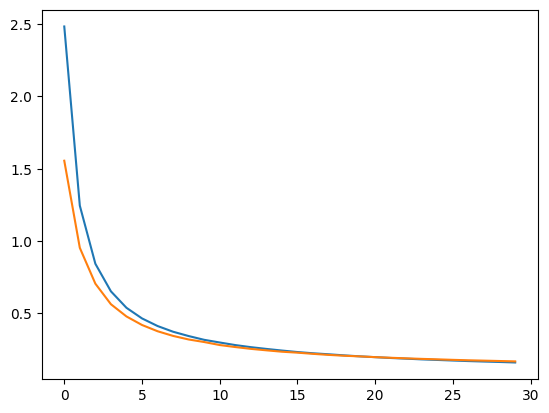

In [14]:
plt.plot(train_losses)
plt.plot(val_losses)